# Beamline 8.3.2 Reconstruction

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget
import sys
import os
import multiprocessing as mp
os.environ['NUMEXPR_MAX_THREADS'] = str(mp.cpu_count()) # to avoid numexpr warning
os.environ['TOMOPY_PYTHON_THREADS'] = str(mp.cpu_count()) # to avoid numexpr warning
import time
import numexpr
import numpy as np
from skimage import transform, filters, io
import tomopy
import svmbir
import dxchange
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact, fixed, FloatSlider, IntSlider
import ALS_recon_helper as als
import util
import copy
import pandas as pd
import base64
import pickle

from pathlib import Path


use_gpu = als.check_for_gpu()
layout = widgets.Layout(width='auto', height='40px')

astropy module not found
olefile module not found


## Choose Data

In [2]:
dataDir = "/global/cfs/cdirs/als/users/tomography_notebooks/example_data" # where is the raw data
basepath = Path(dataDir)
filelist, names = als.get_directory_filelist(dataDir)
file_choice = als.make_file_selector(filelist, names, dataDir)
widgets.Box([widgets.Label(value='Make a File Selection'), file_choice])
display(file_choice)

interactive(children=(Select(description='files', layout=Layout(width='max-content'), options=('14: 20191016_0…

## Find Center of Rotation (COR)
##### Check COR by manually aligning 0 and 180 degree projections
Note: not doing anything with y shift at the moment (could use as constant rotation about ray-axis )

Output()

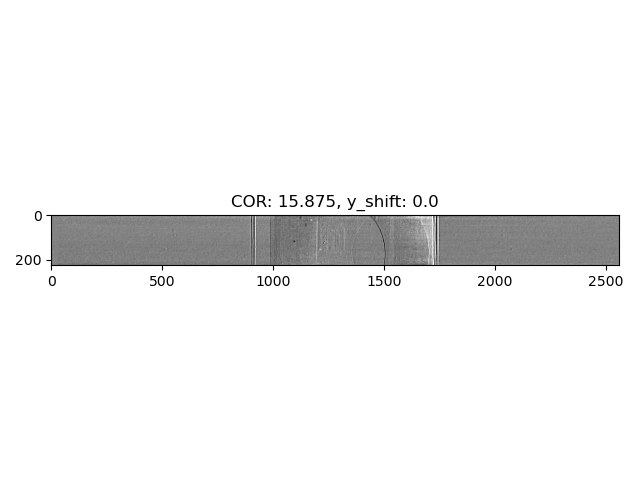

In [3]:
metadata = als.read_metadata(file_choice.result[0], print_flag = False)
tomo, _ = als.read_data(file_choice.result[0], proj=slice(0,None,metadata['numangles']-1), downsample_factor=None)
cor_init = als.auto_find_cor(file_choice.result[0])
first_proj, last_proj_flipped = tomo[0], np.fliplr(tomo[-1])

axs, img, cor_sliders, cor_out = als.plot_0_and_180_proj_diff(first_proj,last_proj_flipped,
                                                                                     init_cor=-2*cor_init,fignum=0)
display(cor_sliders,cor_out)

## Choose Reconstruction Parameters

### Parameters

#### 1. Alignment
* **COR:**
Initializes to value found above, but can fine tune if desred. With mismatched COR, arc/shadow artifacts appear in image. Adjust COR to minimize artifacts.

#### 2. Resolution
*Note: On NERSC, reconstruction takes ~2-4 sec/slice with GPU, ~30 sec/slice on CPU at full resolution (1313 ang x 2560 rays).*

* **Angle Downsampling:**
Downsampling angles by 2x reduces reconstruction time by ~2x, but may introduce streaks through center.

* **Projection Downsampling:**
Downsampling projections by 2x reduces spatial resolution by 2x, reconstruction time by ~4x (minus loading time).

#### 3. Thresholding
* **Minimum transmission:**
Threshold for pre-log, normalized sinogram. A higher value can reduce streaking artifacts between bright features, but also biases image down (ie darker). Set to 0 to turn off.

#### 4. Ring Removal
*Note: strong stripe removal takes time, can reduce resolution and sometimes even introduce artifacts too, so only use as much as you need to remove visible rings

* **Small Ring Size:**
Window size of the median filter to remove small stripes. Larger is stronger but takes longer. Set to appx width of small stripes. Always choose odd value, set to 1 to turn off.

* **Large Ring Size:**
Window size of the median filter to remove large stripes. Set to appx width of large stripes -- should be larger value than Small Ring Size. Always choose odd value, set to 1 to turn off.

* **Ring Removal SNR:**
Sensitivity of large stripe detection method. Smaller is more sensitive. No affect on small stripes. Recommended values: 1.1 -- 3.0.

Box(children=(VBox(children=(Label(value='Recon 1', layout=Layout(justify_content='center')), Dropdown(descrip…

Output()

Output()

interactive(children=(FloatRangeSlider(value=(-0.0023326706676743926, 0.0037238136539235666), description='Col…

interactive(children=(IntSlider(value=0, description='Projection', layout=Layout(width='50%'), max=768), Outpu…

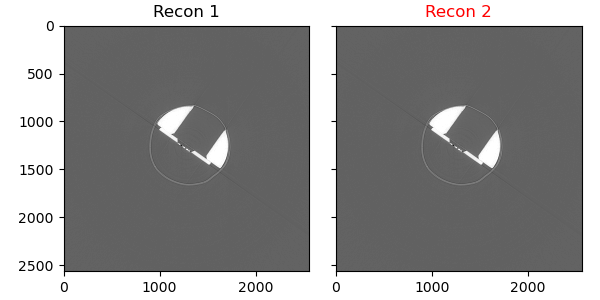

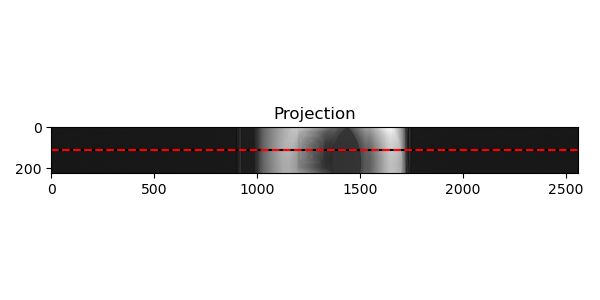

In [4]:
tomo, angles = als.read_data(file_choice.result[0],
                             proj=slice(0,-1,8),
                             sino=slice(metadata["numslices"]//2,metadata["numslices"]//2+1,1),
                             downsample_factor=1)
cor = -cor_sliders.children[0].value/2
recon_init = als.astra_fbp_recon(tomo, angles, COR=cor, fc=1, gpu=use_gpu).squeeze()
clim_init = [np.percentile(recon_init,1),np.percentile(recon_init,99)]

if plt.fignum_exists(1): plt.close(1)
recon_comparison_fig, recon_comparison_axs = plt.subplots(1,2,num=1,figsize=(6,3),sharex=True,sharey=True)
recon_comparison_img = [None, None]
recon_comparison_img[0] = recon_comparison_axs[0].imshow(recon_init,cmap='gray')
recon_comparison_axs[0].set_title('Recon 1')
recon_comparison_img[1] = recon_comparison_axs[1].imshow(recon_init,cmap='gray')
recon_comparison_axs[1].set_title('Recon 2',color='r')
plt.tight_layout()
if plt.fignum_exists(2): plt.close(2)
proj_fig, proj_axs = plt.subplots(1,1,num=2,figsize=(6,3),sharex=True,sharey=True)
proj_img = proj_axs.imshow(first_proj,cmap='gray')
hline_handles = [None, None]
hline_handles[0] = proj_axs.axhline(y=0,color='k',linestyle='-')
hline_handles[1] = proj_axs.axhline(y=0,color='r',linestyle='--')
proj_axs.set_title('Projection')
plt.tight_layout()

recon1_widgets, out1 = util.reconstruction_parameter_options(file_choice.result[0],metadata,cor,use_gpu,recon_comparison_img[0],hline_handles[0],'Recon 1')
recon2_widgets, out2 = util.reconstruction_parameter_options(file_choice.result[0],metadata,cor,use_gpu,recon_comparison_img[1],hline_handles[1],'Recon 2')

clim_slider = widgets.interactive(als.set_clim, img=widgets.fixed(recon_comparison_img),
                              clims=widgets.FloatRangeSlider(description='Color Scale', layout=widgets.Layout(width='50%'),
                                                                   min=recon_init.min(), max=recon_init.max(),
                                                                   step=(recon_init.max()-recon_init.min())/500, value=clim_init,
                                                                   readout=True, readout_format='.2e')
                                 )
proj_slider = widgets.interactive(als.set_proj, path=widgets.fixed(file_choice.result[0]), img=widgets.fixed(proj_img),
                              proj_num=widgets.IntSlider(description='Projection', layout=widgets.Layout(width='50%'),
                                                                   min=0, max=metadata["numangles"]-1,
                                                                   step=1, value=0)
                                 )

box_layout = widgets.Layout(width='100%',
                            height='auto'
                           )
box = widgets.Box(children=[widgets.VBox(recon1_widgets), widgets.VBox(recon2_widgets)], layout=box_layout)
# box = widgets.HBox([widgets.VBox(recon1_widgets), widgets.VBox(recon2_widgets)])
display(box, out1, out2)
display(clim_slider)             

display(proj_slider)

### Choose final settings
##### Note: Boxes above are for visualization and testing only. This cell will be used for final reconstruction

In [14]:
data_settings = {
    "path": file_choice.result[0], # don't change
    "name": os.path.split(os.path.splitext(file_choice.result[0])[0])[-1], # don't change
    "start_slice": 0,
    "stop_slice": metadata['numslices'],
    "angles_ind": slice(0,-1,1), # use every angle 
    "proj_downsample": 1,
    "outputDir": als.get_scratch_path() + "/tomo_data/", # existibg folder where you can write lots of data
    "subdirectoryname": 'test' # subfolder where reconstuctions will be saved (can be empty)
}

preprocess_settings = {
    "minimum_transmission": 0.,
    "snr": 3., 
    "la_size": 11,
    "sm_size": 21,
}

recon_settings = {
    "COR": -53.50/data_settings["proj_downsample"], # important to divide by projection downsampling factor
    "fc": 1.0, 
    "use_gpu": use_gpu
}

settings = {"data": data_settings, "preprocess": preprocess_settings, "recon": recon_settings}
for subset in settings:
    print('\n' + subset.upper())
    for key in settings[subset]:
        print(f"{key}: {settings[subset][key]}")


DATA
path: /global/cfs/cdirs/als/users/tomography_notebooks/example_data/20191016_095526_test_after_power_outage.h5
name: 20191016_095526_test_after_power_outage
start_slice: 0
stop_slice: 224
angles_ind: slice(0, -1, 1)
proj_downsample: 1
outputDir: /pscratch/sd/d/dperl/tomo_data/
subdirectoryname: test

PREPROCESS
minimum_transmission: 0.0
snr: 3.0
la_size: 11
sm_size: 21

RECON
COR: -53.5
fc: 1.0
use_gpu: True


### Reconstruct and save 3D volume in notebook
##### *Note: For more efficient workflow, submit reconstruction to NERSC batch job (see below)*

In [15]:
nchunk = 100 # Balance between available cpus and memory (larger value can be more parallelized but uses more memory). 50 was empirically chosen on Perlmutter exclusive node, though 100 was more or less the same.
saveDir = os.path.join(settings["data"]["outputDir"],settings["data"]["subdirectoryname"],settings["data"]["name"])
if not os.path.exists(saveDir): os.makedirs(saveDir)
saveName = os.path.join(saveDir,"img")
for i in range(np.ceil((settings["data"]['stop_slice']-settings["data"]['start_slice'])/nchunk).astype(int)):
    start_iter = settings["data"]['start_slice']+i*nchunk
    stop_iter = np.minimum(start_iter+nchunk,settings["data"]['stop_slice'])
    print(f"Starting recon of slices {start_iter}-{stop_iter}...",end=' ')
    tic = time.time()

    recon = als.default_reconstruction(path=settings["data"]["path"],
                           angles_ind=settings["data"]['angles_ind'],
                           slices_ind=slice(start_iter,stop_iter,1),
                           proj_downsample=settings["data"]["proj_downsample"],
                           COR=settings["recon"]["COR"],
                           fc=settings["recon"]["fc"],
                           preprocessing_args=settings["preprocess"],
                           use_gpu=settings["recon"]["use_gpu"])

    print(f"Finished: took {time.time()-tic} sec. Saving files...")
    dxchange.write_tiff_stack(recon, fname=saveName, start=start_iter)

Starting recon of slices 0-100... Finished: took 11.360706806182861 sec. Saving files...
Starting recon of slices 100-200... Finished: took 11.96574878692627 sec. Saving files...
Starting recon of slices 200-224... Finished: took 4.467612266540527 sec. Saving files...


### Reconstruct and save 3D volume with NERSC batch job
##### 1. The cell below prepares the config script needed to submit a job

In [18]:
import batch_run

with open ("template_job.txt", "r") as t:
    template = t.read()
    
configsDir = Path(os.path.join(settings["data"]["outputDir"],settings["data"]["subdirectoryname"],"configs/"))
if not configsDir.exists():
    os.mkdir(configsDir)

config_script_name = os.path.join(configsDir,"config_"+settings["data"]["name"]+".sh")    
enc = batch_run.dictionary_prep(settings)
with open(config_script_name, 'w') as f:
    script = template
    script += "\n"
    script += "cd " + os.getcwd()
    script += "\n"
    script += "python run.py"
    script += " '" + enc + "'"
    f.write(script)
    f.close()
    
# list configsDir
os.system(f"ls -l {configsDir}") 

total 5
-rw-rw---- 1 dperl als 992 Jul  7 16:12 config_20180309_162630_fly_z30mm_20keV_3p3umPix.sh
-rw-rw---- 1 dperl als 960 Jul  7 15:01 config_20190627_142116_bread_crust.sh


0

##### 2. Open a terminal (from blue plus in upper left) and submit the batch job through terminal with the command,
##### `sbatch [job script name]`

### Alternatively, you can submit all job scripts in a folder using helper bash script
##### 1. Modify first line of submit_all_jobs_template.sh with your configs directory (from cell below)
##### 2. Save as new bash script (eg. my_submit_all_jobs.sh)
##### 3. In terminal, `source [bash script name]`

In [19]:
#Please use this to change out the filepath in the 
#bash script (the helper script to loop and submit all configs).
print(str(configsDir.absolute())+"/*")

/pscratch/sd/d/dperl/tomo_data/test/configs/*


### Optional: SVMBIR reconstruction (for better image quality)
##### Note: SVMBIR is MUCH slower. At full resolution (1313 ang x 2560 rays), takes ~2-4 min/slice with all 128 exclusive node threads (uses CPU only). Downsampling by 2x reduces time by ~4x (plus loading time)

In [ ]:
%%time
"""
########## PARAMETERS ##########

# Default settings are typically good, don't necessarily need to change

### p ###
smoothing parameter for large grayscale differences (ie contrasting pixels). Between 1 and 2 (1 = total variation regularization, 2 = Tikhonov regularization)

### q ###
# smoothing parameter for small grayscale differences (ie. similar pixels). Between p and 2

### T ###
# transition value from q to p (in pixel grayscale difference). Must be > 0

### sharpness ###
# stregth of smoothing -- lower is more smooth. +1 change is equivalent to +6 dB snr. Can typically just change one or the other

### snr_dB ###
# strength of smoothing -- lower is more smooth. +6 dB is equivalent to +1 sharpness. Can typically just change one or the other
"""
p = 1.2 
q = 2 
T = 0.1 
sharpness = 0 
snr_dB = 40.0 
########## dont touch code below ##########

svmbir_settings = {
    "p": p, 
    "q": q, 
    "T": T,
    "sharpness": sharpness, 
    "snr_dB": snr_dB,
    "max_iter": 100,
    "COR": process_settings['COR']/process_settings['downsample_factor'],
    "init_image": preprocess_recon
}

tomo, angles = als.read_data(settings["path"], sino=settings["slices_ind"], downsample_factor=settings["downsample_factor"],args=process_settings)
svmbir_recon = als.svmbir_recon(tomo,angles,**svmbir_settings)
print(f"Finisehd reconstruction, size: {fbp_recon.shape}")
print('')
print('This took:')

In [ ]:
img, axs, clim_slider = als.plot_recon_comparison(preprocess_recon, svmbir_recon, titles=['FBP','SVMBIR'], fignum=5, figsize=4)
display(clim_slider)